In [139]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics

import warnings                               
warnings.filterwarnings('ignore')

In [140]:
df = pd.read_csv("train_final_project.csv")

In [141]:
df.shape

(77202, 20)

In [142]:
df.head()

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77202 entries, 0 to 77201
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Datetime                      77202 non-null  object 
 1   ActivePower                   77202 non-null  float64
 2   AmbientTemperatue             76306 non-null  float64
 3   BearingShaftTemperature       50518 non-null  float64
 4   Blade1PitchAngle              33920 non-null  float64
 5   Blade2PitchAngle              33837 non-null  float64
 6   Blade3PitchAngle              33837 non-null  float64
 7   GearboxBearingTemperature     50520 non-null  float64
 8   GearboxOilTemperature         50532 non-null  float64
 9   GeneratorRPM                  50528 non-null  float64
 10  GeneratorWinding1Temperature  50546 non-null  float64
 11  GeneratorWinding2Temperature  50553 non-null  float64
 12  HubTemperature                50410 non-null  float64
 13  M

In [144]:
df.isnull().sum()

Datetime                            0
ActivePower                         0
AmbientTemperatue                 896
BearingShaftTemperature         26684
Blade1PitchAngle                43282
Blade2PitchAngle                43365
Blade3PitchAngle                43365
GearboxBearingTemperature       26682
GearboxOilTemperature           26670
GeneratorRPM                    26674
GeneratorWinding1Temperature    26656
GeneratorWinding2Temperature    26649
HubTemperature                  26792
MainBoxTemperature              26704
NacellePosition                 20424
ReactivePower                      42
RotorRPM                        26680
TurbineStatus                   26466
WindDirection                   20424
WindSpeed                         308
dtype: int64

In [145]:
## converting to datetime format
df['Datetime']=pd.to_datetime(df['Datetime'])
df.sort_values(by=['Datetime'],ascending=True)
df['Date'] = df['Datetime'].dt.date


In [146]:
data_by_day=pd.DataFrame(df.groupby('Date')[['ActivePower','WindSpeed','WindDirection','AmbientTemperatue']].mean())

In [147]:
data_by_day

,ActivePower,WindSpeed,WindDirection,AmbientTemperatue
Date,,,,
2018-01-01,366.223561,5.263797,276.727612,25.528849
2018-01-02,462.550740,5.390719,274.105603,25.357526
2018-01-03,454.417752,5.295225,286.369130,24.379363
2018-01-04,369.952190,5.094994,284.445471,24.912347
2018-01-05,319.446595,4.915224,292.013293,23.535679
...,...,...,...,...
2020-03-11,466.289248,5.385570,183.729298,28.276232
2020-03-12,570.315539,5.693483,180.773250,29.094133
2020-03-13,619.637333,5.765318,187.621975,30.088163


In [148]:
def calculate_rmse(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    return (mse)**2

In [149]:
def adf_test(timeseries):
   print ('Results of Augmented Dickey-Fuller Test:')
   
   dftest = adfuller(timeseries, autolag='AIC')
    
   print("ADF Test Results for AR Process (a):")
   print("ADF Statistic:", dftest[0])
   print("P-Value:", dftest[1])
   print("Conclusion: The process (a) is", "stationary." if dftest[1] < 0.05 else "non-stationary.")

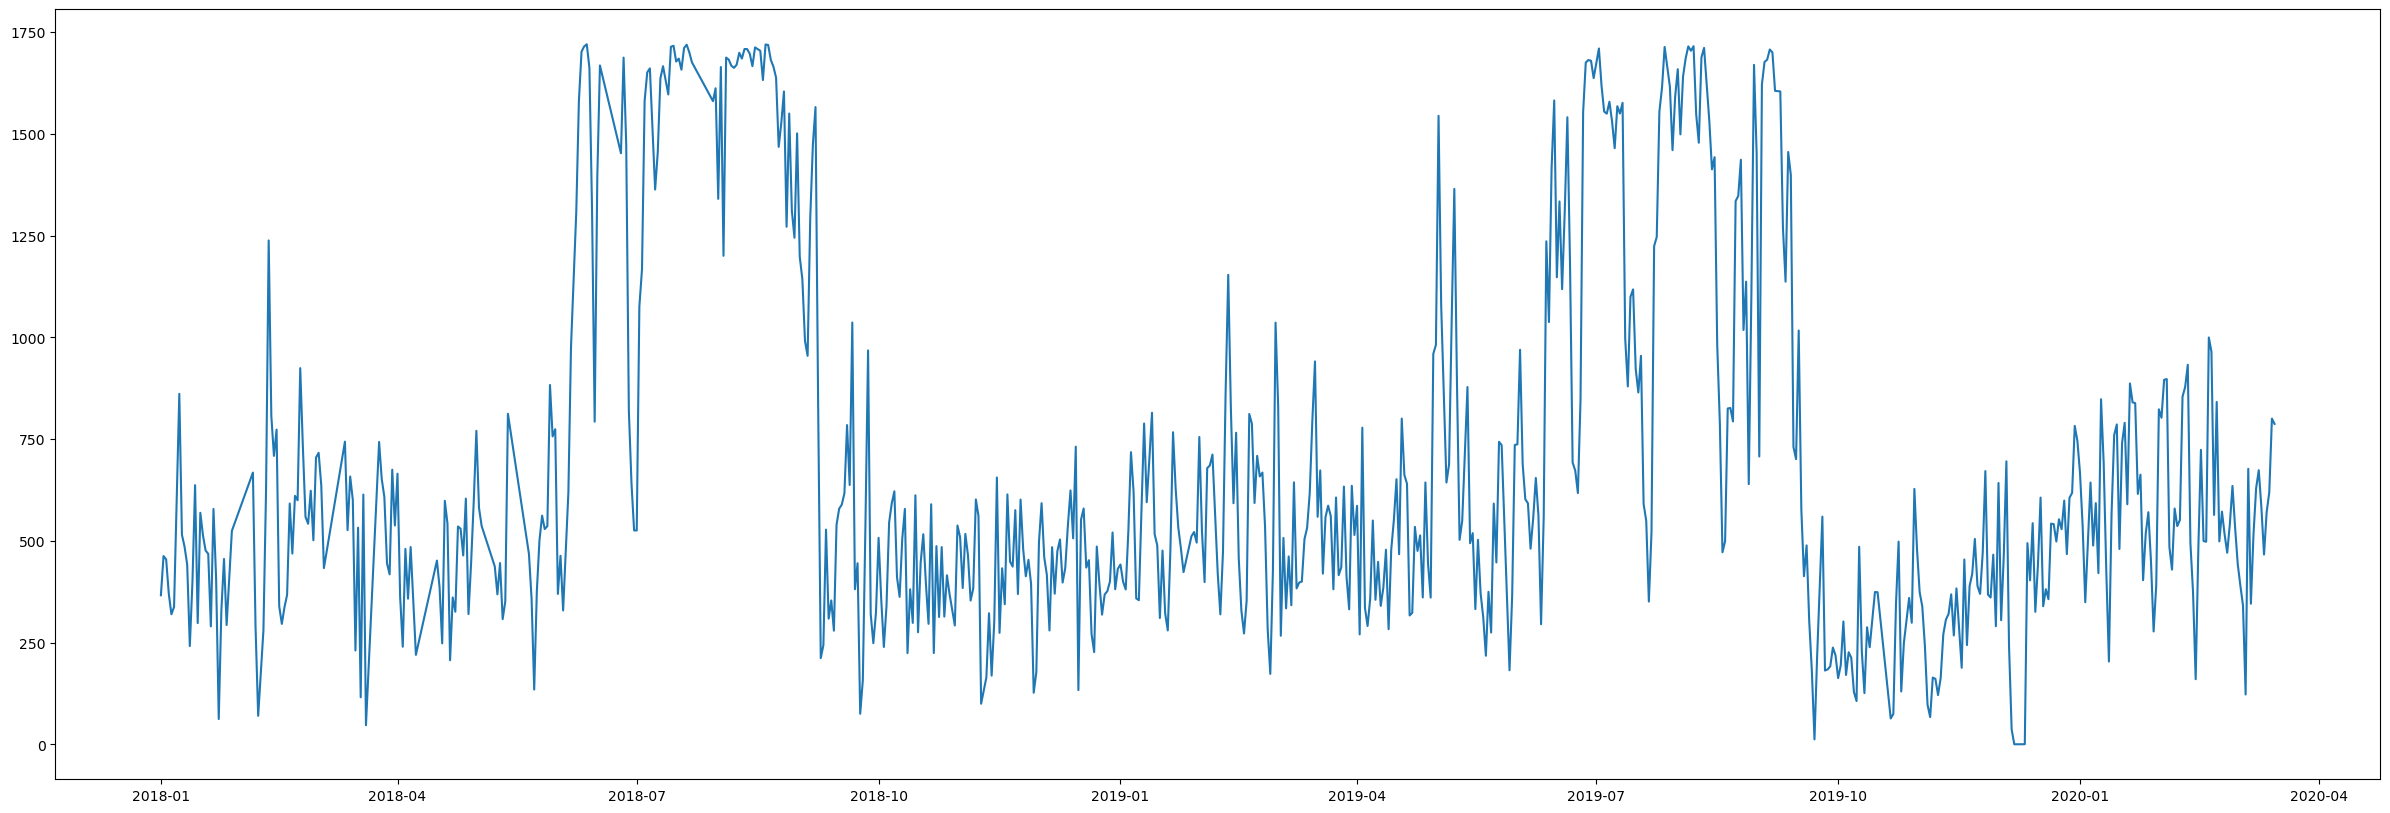

In [150]:
plt.figure(figsize=(30, 10))

plt.plot(data_by_day['ActivePower'])
plt.show()



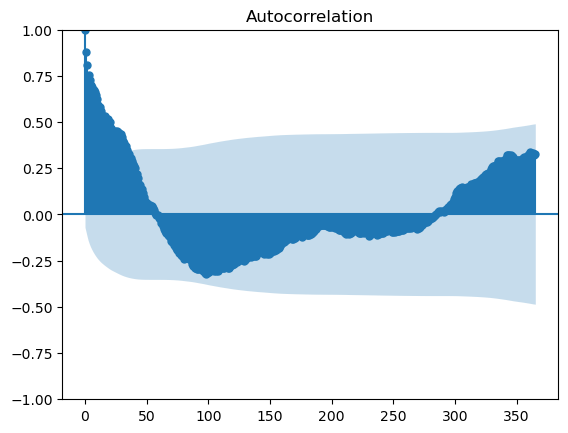

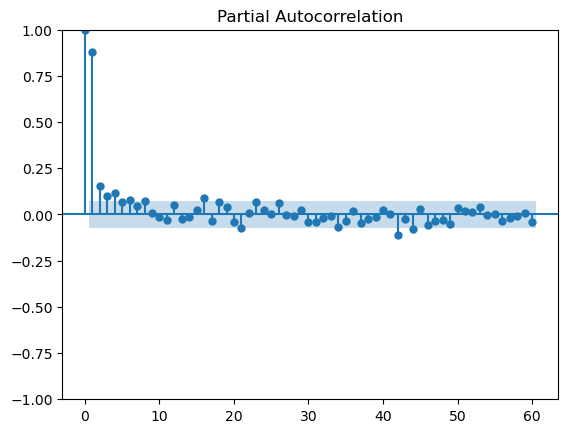

In [151]:
plot_acf(data_by_day['ActivePower'],lags=365)
plt.show()

plot_pacf(data_by_day['ActivePower'],lags=60)
plt.show()

In [153]:
adf_test(data_by_day['ActivePower'])

Results of Augmented Dickey-Fuller Test:
ADF Test Results for AR Process (a):
ADF Statistic: -3.237316142309058
P-Value: 0.01792376595212781
Conclusion: The process (a) is stationary.


Form the test we can say that data is stationary but its not sure from plots, so to de trend and de sesonlize

In [154]:
def diff(data, interval):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

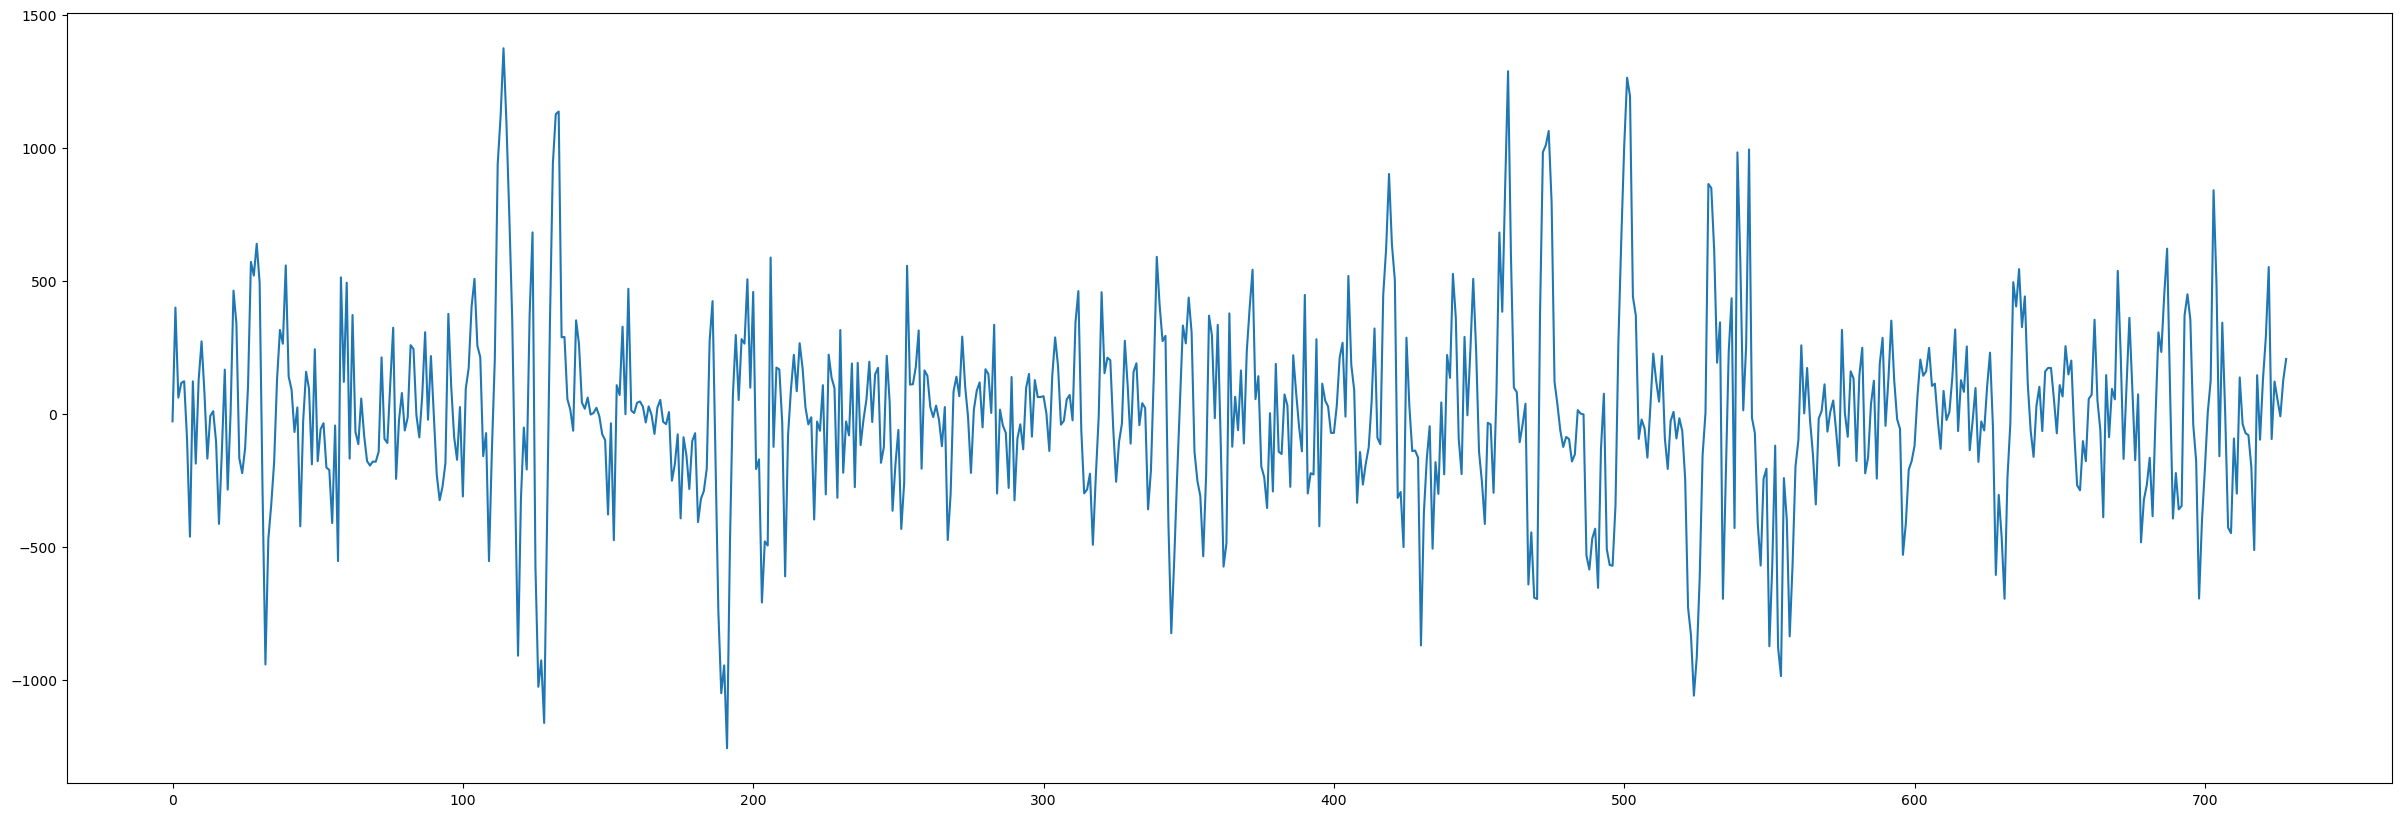

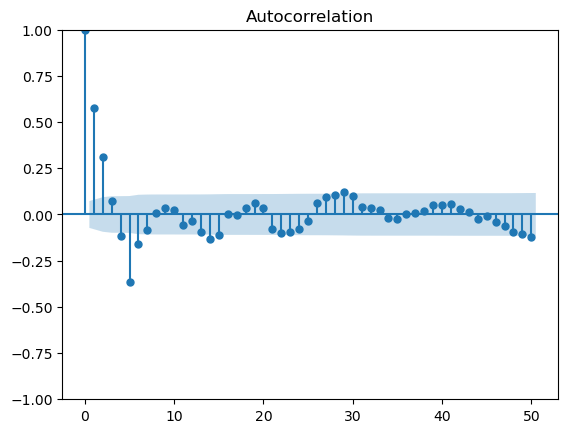

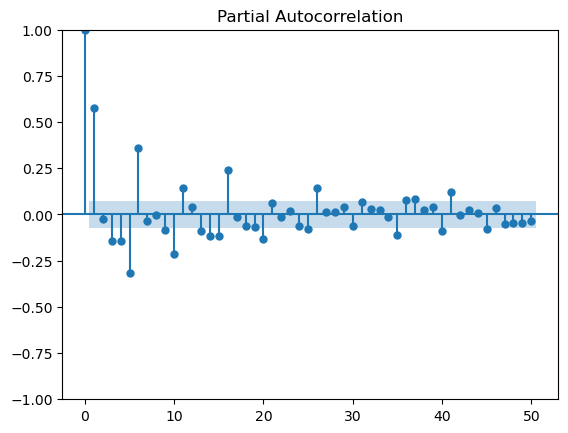

Results of Augmented Dickey-Fuller Test:
ADF Test Results for AR Process (a):
ADF Statistic: -7.15425158016096
P-Value: 3.084071261481551e-10
Conclusion: The process (a) is stationary.


In [155]:
deseason_df = diff(data_by_day['ActivePower'], 5)
plt.figure(figsize=(30, 10))
plt.plot(deseason_df)
plt.show()
plot_acf(deseason_df ,lags=50) 
plot_pacf(deseason_df ,lags=50) 
plt.show()
adf_test(deseason_df)

In [156]:
from statsmodels.tsa.stattools import arma_order_select_ic
arma_order_select_ic(data_by_day['ActivePower'],max_ar=4, max_ma=5, ic='aic')

{'aic':               0             1             2             3             4  \
 0  11077.133972  10558.924038  10317.047931  10211.059837  10149.232998   
 1   9995.050380   9974.064219   9963.467861   9956.518551   9957.805760   
 2   9979.725026   9954.158647   9956.158568   9957.495580   9959.468339   
 3   9974.469113   9956.158559   9955.274173   9956.755938   9958.751471   
 4   9966.613251   9957.446862   9956.758442   9958.739063   9960.733045   
 
               5  
 0  10111.556870  
 1   9959.190299  
 2   9961.197495  
 3   9960.503980  
 4   9959.684207  ,
 'aic_min_order': (2, 1)}

In [157]:
arma_order_select_ic(data_by_day['ActivePower'],max_ar=6, max_ma=6, ic='bic')

{'bic':               0             1             2             3             4  \
 0  11086.330990  10572.719565  10335.441967  10234.052382  10176.824052   
 1  10008.845907   9992.458255   9986.460406   9984.109605   9989.995324   
 2   9998.119062   9977.151192   9983.749622   9989.685143   9996.256412   
 3   9997.461659   9983.749613   9987.463736   9993.544011  10000.138053   
 4   9994.204305   9989.636425   9993.546514  10000.125644  10006.718136   
 5   9997.453709   9996.213239  10000.138424  10006.720173  10012.891042   
 6   9999.200639  10002.315341  10006.349377  10012.825509  10009.447543   
 
               5             6  
 0  10143.746433  10117.691536  
 1   9995.978371  10002.521256  
 2  10002.584077  10006.335137  
 3  10006.489070  10012.950295  
 4  10010.267806  10018.155560  
 5  10008.200708  10014.176070  
 6  10014.474934  10022.239951  ,
 'bic_min_order': (2, 1)}

## ETS

In [158]:
train, test = data_by_day[:-15], data_by_day[-15:]

In [159]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_ets = ExponentialSmoothing(train['ActivePower'], trend="add", seasonal="add", seasonal_periods=12, damped_trend=False).fit()

In [161]:
preds_ets = pd.DataFrame(model_ets.forecast(len(test)))

In [162]:
preds_ets

,0
719,575.442050
720,590.158052
721,569.058200
722,579.601066
723,610.452862
724,568.253656
725,563.833758
726,558.590295
727,601.112890
728,634.267047


In [163]:
np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], pred_1))

176.4568129673209

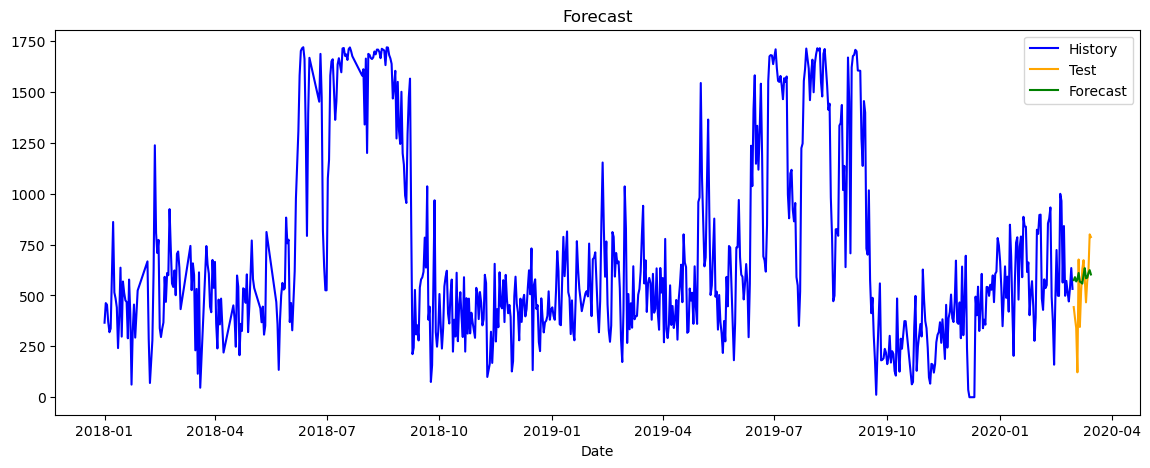

In [164]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
train['Date'] = train.index.values
test['Date'] = test.index.values
pred_1['Date'] = test.index.values
train.plot(kind='line',x='Date' , y='ActivePower', color='blue', label='History', ax=ax)
test.plot(kind='line',x='Date' , y='ActivePower', color='orange', label='Test', ax=ax)
pred_1.plot(kind='line', x='Date', y=0, color='green', label='Forecast', ax=ax)
plt.title('Forecast')
plt.show()

## SARIMAX

In [168]:
def evaluate_models_cv_sarimax(dataset,exog, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    K=5
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size=15
                            train_size=len(dataset)-validation_size*K
                            rmse=0
                            for k in range(0,5):
                                train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                exog_train, exog_test = exog[0:train_size+k*validation_size],exog[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                model = sm.tsa.SARIMAX(train, order=trend_order, seasonal_order=seasonal_order, exog=exog_train) #each step: rolling one step forward to update the train se
                                model_fit = model.fit(disp=False)
                                predictions=model_fit.forecast(validation_size,exog=exog_test)
                                rmse = rmse+np.sqrt(skmetrics.mean_squared_error(test, predictions))
                            rmse_avg=rmse/3
                            result.append((cfg, rmse_avg))
                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('SARIMAX%s RMSE=%.3f' % (cfg,rmse_avg))
    print('Best SARIMAX%s RMSE=%.3f' % (best_cfg, best_rmse))

In [169]:
data_by_day=data_by_day.dropna()

In [184]:
# order selection
p=[0,1,2]
d=[1]
q=[0,1,2,3]
P=[0,1,2]
D=[1]
Q=[1]
m=30
evaluate_models_cv_sarimax(data_by_day['ActivePower'],data_by_day[['WindSpeed','WindDirection','AmbientTemperatue']], p,d,q,P,D,Q,m)

SARIMAX[(0, 1, 0), (0, 1, 1, 30)] RMSE=115.047
SARIMAX[(0, 1, 1), (0, 1, 1, 30)] RMSE=107.099


In [172]:
#model = SARIMAX(data_by_day['ActivePower'],order=(0,1,2),seasonal_order=(0, 1, 1, 30)).fit()
model = sm.tsa.SARIMAX(data_by_day['ActivePower'], order=(0,1,2), seasonal_order=(0, 1, 1, 30)).fit() #each step: rolling one step forward to update the train se
                                

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64944D+00    |proj g|=  3.47888D-02


 This problem is unconstrained.



At iterate    5    f=  6.64150D+00    |proj g|=  4.19484D-03

At iterate   10    f=  6.63970D+00    |proj g|=  1.49723D-02

At iterate   15    f=  6.57020D+00    |proj g|=  1.88561D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   2.648D-06   6.570D+00
  F =   6.5696152035648687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [173]:
preds= model.forecast(15)
preds

727    696.339033
728    723.152199
729    706.917254
730    728.043284
731    717.269700
732    641.638076
733    613.877469
734    707.626999
735    633.457242
736    582.795844
737    591.812726
738    593.872851
739    591.924703
740    592.475799
741    643.205916
Name: predicted_mean, dtype: float64

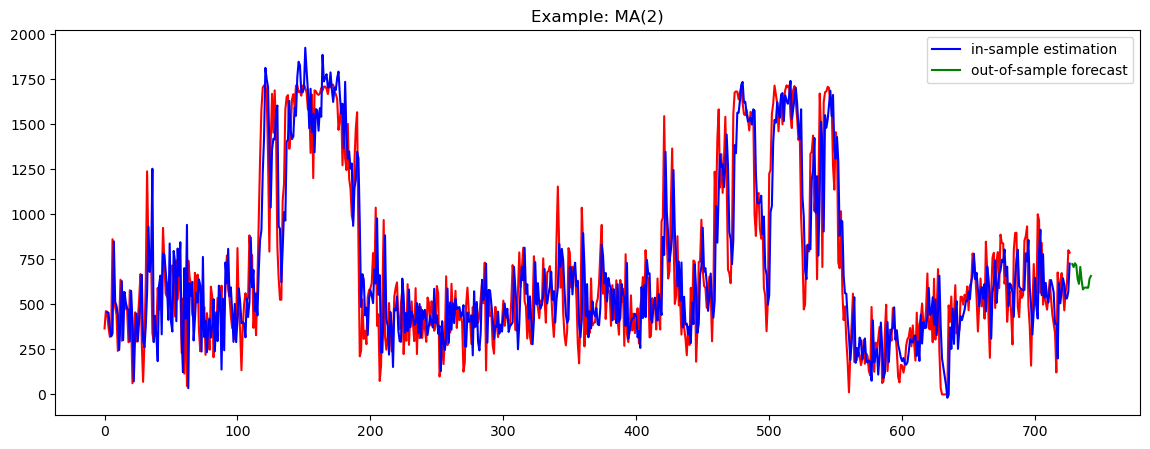

In [174]:
history =  pd.DataFrame(data_by_day['ActivePower'])
history = history.reset_index()
history = history['ActivePower']

pred = model.predict(start=1, end=len(data_by_day['ActivePower'])+15)
prediction = pd.DataFrame(pred)
estimation = prediction[1:len(data_by_day['ActivePower'])-1]
forecast = prediction[len(data_by_day['ActivePower']):len(data_by_day['ActivePower'])+15]

history.columns =['x']
estimation.columns =['x']
forecast.columns =['x']

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history.plot(kind='line',y='x',color='red', label='history', ax=ax)
estimation.plot(kind='line',y='x',color='blue', label='in-sample estimation', ax=ax)
forecast.plot(kind='line',y='x',color='green', label='out-of-sample forecast', ax=ax)
plt.title('Example: MA(2)')
plt.show()

In [177]:
start_date = '2020-03-16'
end_date = '2020-03-30'

# Create a list of dates
date_list = pd.date_range(start=start_date, end=end_date, freq='D').strftime('%Y-%m-%d').tolist()

df_forecast = pd.DataFrame(preds.values, date_list, columns=['Forecasting'])
df_forecast['Date'] = df_forecast.index.values
df_forecast

,Forecasting,Date
2020-03-16,696.339033,2020-03-16
2020-03-17,723.152199,2020-03-17
2020-03-18,706.917254,2020-03-18
2020-03-19,728.043284,2020-03-19
2020-03-20,717.269700,2020-03-20
2020-03-21,641.638076,2020-03-21
2020-03-22,613.877469,2020-03-22
2020-03-23,707.626999,2020-03-23
2020-03-24,633.457242,2020-03-24
2020-03-25,582.795844,2020-03-25


In [181]:
df_forecast = df_forecast[['Date','Forecasting']]
df_forecast.to_csv('~/Documents/test_forecast.csv', index=False)